# Исследовательский анализ данных. Яндекс Недвижимость

## Введение

В моем распоряжении имеются данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

**Задача** — выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.

О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические. Например, к первому типу относятся площадь квартиры, её этаж и количество балконов, ко второму — расстояния до центра города, аэропорта и ближайшего парка.

## Загрузка библиотек и данных. Обзор основной информации о данных

In [7]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('C:/Users/m.v.kuznetsov/Downloads/real_estate_data.csv', sep='\t')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [10]:
df.duplicated().sum()

0

Перед редактированием пропусков необходимо переименовать некоторые столбцы.

In [11]:
df = df.rename(columns={
    'cityCenters_nearest':'city_centers_nearest', 
    'parks_around3000':'parks_around_3000', 
    'ponds_around3000':'ponds_around_3000'
})

## Обработка пропусков

In [12]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Я думаю, очень важно указать в базе данных, что объект недвижимости является апартаментами, так как в ней в этом случае невозможно сделать постоянную регистрацию. Есть и другие нюансы. Поэтому если в базе нет пометки об этой информации, то, скорее всего, это не апартаменты. Поэтому пропуски можно заменить значениями False

In [13]:
df['is_apartment'] = df['is_apartment'].fillna(value=False)

Подобный принцип можно применить и к столбцу 'balcony'. Если их количество не указано, то можно смело вставить значение равное 0.

In [14]:
df['balcony'] = df['balcony'].fillna(value=0)

Cтолбцов с пропущенными значениями месторасположения всего 49, их можно удалить.

In [15]:
df = df.dropna(subset='locality_name')

In [16]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
city_centers_nearest     5511
parks_around_3000        5510
parks_nearest           15586
ponds_around_3000        5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

Займемся пропусками в столбцах 'parks_around_3000' и 'ponds_around_3000'. 
У этих данных одинаковый смысл заполнения, число пропусков одинаковое. Возможно, что эти пропуски связаны с тем, 
что в пределах 3 км от объекта недвижимости нет ни парков, ни водоемов. Можно также сделать вывод, что у всех объектов, 
где пропущены значения в одном столбце, пропущены значения и в другом. Проверим последнее утверждение.

In [17]:
df[(df['parks_around_3000'].isna()) & (df['ponds_around_3000'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,False,...,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,False,...,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,False,...,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,False,...,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,False,...,NaN,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,False,...,5.50,0.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,False,...,6.00,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,False,...,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,False,...,NaN,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Последнее утверждение подтвердилось. Теперь можем заполнить эти пропуски значениями 0.

In [18]:
df['parks_around_3000'] = df['parks_around_3000'].fillna(value=0)
df['ponds_around_3000'] = df['ponds_around_3000'].fillna(value=0)

Есть предположение, что пропуски в столбце 'airports_nearest' связаны с тем, что эти бъекты недвижимости
находятся не в Санкт-Петеребурге непосредственно, в единственном городе, где пассажирский аэропорт. Да, в малых городах есть 
какие-то аэродромы, но они не используются для перевозки пассажиров.Эти пропуски можно заполнить медианным значением,
посчитанным среди имеющихся данных для конкретной локации

In [19]:
for i in df['locality_name'].unique():
    df.loc[(df['locality_name'] == i) & (df['airports_nearest'].isna()), 'airports_nearest'] = \
    df.loc[(df['locality_name'] == i), 'airports_nearest'].median()

In [20]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5386
city_centers_nearest     5511
parks_around_3000           0
parks_nearest           15586
ponds_around_3000           0
ponds_nearest           14565
days_exposition          3180
dtype: int64

Видим, что число пропусков в колонке 'airports_nearest' уменьшилось примерно на 200. Значит, для некоторых населенных пунктов
расстояние до аэропорта ни в одной из строк не указано. Что ж, пропуски придется оставить, их очень много. А вручную их
заполнять не вариант.

По аналогии с предыдущим случаем обработаем пропуски в столбце 'city_centers_nearest'.

In [21]:
for i in df['locality_name'].unique():
    df.loc[(df['locality_name'] == i) & (df['city_centers_nearest'].isna()), 'city_centers_nearest'] = \
    df.loc[(df['locality_name'] == i), 'city_centers_nearest'].median()

In [22]:
df.isnull().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5386
city_centers_nearest     5386
parks_around_3000           0
parks_nearest           15586
ponds_around_3000           0
ponds_nearest           14565
days_exposition          3180
dtype: int64

Число пропусков в столбце 'city_centers_nearest' уменьшилось на такое же количество, как и в предыдущем случае. Вероятно, эти пропуски были с деланы в одних и тех же колонках. Оставляем эти пропуски, так как их много.

Есть предположение, что пропуски в столбце 'parks_nearest' связаны с тем, что в радиусе 3000 м от объекта недвижимости нет
парков. Проверим.

In [23]:
df[(df['parks_nearest'].isnull()) & (df['parks_around_3000']==0)].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,False,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,False,...,9.10,0.0,городской посёлок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,False,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,False,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,False,...,8.81,0.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.5,9.0,43.60,7,False,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0
11,9,3300000.0,44.00,2018-08-27T00:00:00,2,NaN,5.0,31.00,4,False,...,6.00,1.0,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,False,...,9.00,0.0,Сертолово,NaN,NaN,0.0,NaN,0.0,NaN,90.0
14,1,4400000.0,36.00,2016-06-23T00:00:00,1,NaN,6.0,17.00,1,False,...,8.00,0.0,Пушкин,20782.0,30759.0,0.0,NaN,1.0,96.0,203.0
17,6,4180000.0,36.00,2016-09-09T00:00:00,1,NaN,17.0,16.50,7,False,...,11.00,1.0,Санкт-Петербург,33564.0,14616.0,0.0,NaN,1.0,859.0,571.0


Предположение подтвердилось, теперь можно заполнить эти пропуски, например, значением 3001. Когда речь будет идти о расстоянии от парка более 3000 м, будем объединять эту категорию в одну, т. е. не будем проводить детализации. 

In [24]:
df['parks_nearest'] = df['parks_nearest'].fillna(value=3001)

По тому же принципу заполним пропуски в столбце 'ponds_nearest':

In [25]:
df['ponds_nearest'] = df['ponds_nearest'].fillna(value=3001)

Удалим пропуске в столбце floors_total, их всего 85.

In [26]:
df = df.dropna(subset='floors_total')

Чтобы заполнить пропуски в 'living_area' и 'kitchen_area' воспользуемся принципом 
"общая жилая площадь = площадь кухни + жилая площадь". Но в таком случае необходимо, чтобы в строке только лишь в одном
столбце из двух был пропуск. Проверим, сколько строк, где пропущены оба значения.

In [27]:
df[(df['kitchen_area'].isna()) & (df['living_area'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,False,...,NaN,0.0,Коммунар,NaN,NaN,0.0,3001.0,0.0,3001.0,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,False,...,NaN,0.0,поселок городского типа Красный Бор,NaN,NaN,0.0,3001.0,0.0,3001.0,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,NaN,22.0,NaN,3,False,...,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,NaN,13.0,NaN,13,False,...,NaN,0.0,Санкт-Петербург,11125.0,14501.0,0.0,3001.0,0.0,3001.0,336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23632,20,5000000.0,38.0,2018-06-23T00:00:00,1,2.55,16.0,NaN,15,False,...,NaN,1.0,Санкт-Петербург,31118.0,7257.0,1.0,241.0,1.0,230.0,113.0
23642,14,5950000.0,80.3,2018-07-03T00:00:00,3,2.70,12.0,NaN,5,False,...,NaN,0.0,Колпино,27933.0,33719.0,0.0,3001.0,2.0,562.0,60.0
23663,12,6400000.0,88.0,2018-01-12T00:00:00,4,2.55,10.0,NaN,1,False,...,NaN,0.0,Санкт-Петербург,33642.0,13943.0,0.0,3001.0,2.0,844.0,59.0
23670,9,2450000.0,45.6,2018-02-08T00:00:00,1,2.80,9.0,NaN,2,False,...,NaN,0.0,поселок городского типа Синявино,NaN,NaN,0.0,3001.0,0.0,3001.0,45.0


1427 строки. Это меньше 10% от всего датафрейма. Их можно удалить.

In [28]:
df = df.loc[~((df['kitchen_area'].isna()) & (df['living_area'].isna()))]

Создам столбцы разницы общей площади и жилой площади и разницы общей площади и площади кухни:

In [29]:

df['count_liv_area'] = df['total_area'] - df['kitchen_area']
df['count_kitch_area'] = df['total_area'] - df['living_area']

Заполню пропущенные значения из 'kitchen_area' и 'living_area' из соответствующих рассчитанных значений
с учетом количества комнат:

In [30]:
for t in df['rooms'].unique():
    df.loc[(df['rooms'] == t) & (df['living_area'].isna()), 'living_area'] = \
    df.loc[(df['rooms'] == t), 'count_liv_area'].median()

In [31]:
for t in df['rooms'].unique():
    df.loc[(df['rooms'] == t) & (df['kitchen_area'].isna()), 'kitchen_area'] = \
    df.loc[(df['rooms'] == t), 'count_kitch_area'].median()

Теперь 'count_liv_area', 'count_kitch_area' можно удалить:

In [33]:
df = df.drop(columns=['count_liv_area', 'count_kitch_area'])

Пропуски в столбце 'ceiling_height' следует оставить, так как не может быть никакой стратегии по их заполнению. 
Высота потолков не может зависеть ни от одного фактора.Удаление такого большого числа пропуска приведет к искажению выводов.
То же самое и о столбце 'days_exposition', пропуски следует оставить.

## Преобразование формата данных

Преобразуем формат first_day_exposition в datetime для удобства отображения, и чтобы потом можно было вычленять года, дни:

In [34]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

Преобразуем формат некоторых колонок в int так как данные в этих столбцах подразумевают целые числа:

In [35]:
df['floors_total'] = df['floors_total'].astype('int64')
df['balcony'] = df['balcony'].astype('int64')
df['parks_around_3000'] = df['parks_around_3000'].astype('int64')
df['ponds_around_3000'] = df['ponds_around_3000'].astype('int64')

## Устранение неявных дубликатов

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22138 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22138 non-null  int64         
 1   last_price            22138 non-null  float64       
 2   total_area            22138 non-null  float64       
 3   first_day_exposition  22138 non-null  datetime64[ns]
 4   rooms                 22138 non-null  int64         
 5   ceiling_height        13915 non-null  float64       
 6   floors_total          22138 non-null  int64         
 7   living_area           22138 non-null  float64       
 8   floor                 22138 non-null  int64         
 9   is_apartment          22138 non-null  bool          
 10  studio                22138 non-null  bool          
 11  open_plan             22138 non-null  bool          
 12  kitchen_area          22138 non-null  float64       
 13  balcony         

Удалим неявные дубликаты в столбце с названиями населенных пунктов. Cначала проверим, вводились ли названия в разном регистре:

In [37]:
df['low_locality_name'] = df['locality_name'].str.lower()
len(df['low_locality_name'].value_counts()), len(df['locality_name'].value_counts())

(349, 349)

In [38]:
df = df.drop(columns=['low_locality_name'])

Напишем функцию, которая будет возвращать последний элемент из списка определенной ячейки:

In [39]:
def last_word_return(locality_name):
        s = [i for i in locality_name.split()]
        return s[-1]
        
df['modif_locality_name'] = df['locality_name'].apply(last_word_return)

Теперь проверим, действительно ли на последнем в столбце 'modif_locality_name' стоит наименование населенного пункта, а не его тип:

In [40]:
df['modif_locality_name'].sort_values().unique()

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Бор', 'Бугры', 'Будогощь', 'Ваганово', 'Важины',
       'Вартемяги', 'Верево', 'Вещево', 'Виллози', 'Вознесенье',
       'Возрождение', 'Войсковицы', 'Войскорово', 'Володарское',
       'Волосово', 'Волхов', 'Вруда', 'Всеволожск', 'Выборг', 'Вырица',
       'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово', 'Гарболово',
       'Гатчина', 'Гладкое', 'Глажево', 'Глебычево', 'Глинка',
       'Гончарово', 'Горбунки', 'Горка', 'Гостилицы', 'Грива', 'Громово',
       'Девяткино', 'Дзержинского', 'Долина', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жилгородок', 'Жилпосёлок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ивангород', 'Ижора', 'Извара', 'Ильичёво', 'Калитино',
       'Каложицы', 'Кальтино', 'Каменногорск', 'Камышовка', 'Карлино',
       'Ка

В значениях столбца везде топонимы, исключение - километр (посёлок Платформа 69-й километр). Найденные дубликаты - поселок Поляны и поселок Полана (правильно Поляны), поселок Саперное и поселок Саперный (правильно Саперное).

Устраним эти выявленные дубилкаты в столбце 'modif_locality_name':

In [41]:
df.loc[df['modif_locality_name']=='Сапёрный', 'modif_locality_name'] = 'Сапёрное'
df.loc[df['modif_locality_name']=='Поляна', 'modif_locality_name'] = 'Поляны'
df.loc[df['modif_locality_name']=='километр', 'modif_locality_name'] = 'Платформа 69-й километр'

Теперь в столбце 'modif_locality_name' мы получили уникальные названия топонимов, 
если будет нужно необходимо узнать их тип, то можно будет обратиться к оригинальному столбцу.

## Поиск выбивающихся значений

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22138 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22138 non-null  int64         
 1   last_price            22138 non-null  float64       
 2   total_area            22138 non-null  float64       
 3   first_day_exposition  22138 non-null  datetime64[ns]
 4   rooms                 22138 non-null  int64         
 5   ceiling_height        13915 non-null  float64       
 6   floors_total          22138 non-null  int64         
 7   living_area           22138 non-null  float64       
 8   floor                 22138 non-null  int64         
 9   is_apartment          22138 non-null  bool          
 10  studio                22138 non-null  bool          
 11  open_plan             22138 non-null  bool          
 12  kitchen_area          22138 non-null  float64       
 13  balcony         

In [43]:
df['total_images'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35,
       37, 39, 42, 50], dtype=int64)

In [44]:
 df['last_price'].min(), df['last_price'].max()

(12190.0, 763000000.0)

In [45]:
df['total_area'].min(), df['total_area'].max()

(12.0, 900.0)

In [46]:
df['rooms'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19],
      dtype=int64)

In [47]:
df['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.4 ,
         2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,   2.52,
         2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,   2.6 ,
         2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,   2.68,
         2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,   2.76,
         2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,   2.84,
         2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,   2.92,
         2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   3.  ,   3.01,
         3.02,   3.03,   3.04,   3.05,   3.06,   3.07,   3.08,   3.09,
         3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,   3.16,   3.17,
         3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,   3.25,   3.26,
         3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,   3.33,   3.34,
         3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,   3.42,   3.43,
         3.44,   3.45,   3.46,   3.47,   3.48,   3.49,   3.5 ,   3.51,
      

Строки со значениями менее 2 м удалим, как и строки со значеним в 100 м.

In [48]:
df = df.loc[~(df['ceiling_height'] < 2)]
df = df.loc[~(df['ceiling_height'] == 100)]

Значения от 20 до 32 м явно ошибочные, вместо них, скорее всего, нужно ввести от 2.0 до 3.2, соответственно.
Но что делать со значениями от 8.3 до 14, уж больно большие потолки. Значение в 1.4 м очень маленькое.
Посмотрим, сколько таких значений.

In [49]:
df.loc[(df['ceiling_height'] > 8.3) & (df['ceiling_height'] < 20)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,modif_locality_name
15061,19,5600000.0,56.4,2018-05-11,2,14.0,14,32.4,5,False,...,2,Санкт-Петербург,14814.0,13610.0,0,3001.0,0,3001.0,315.0,Санкт-Петербург
22309,20,5300000.0,45.0,2017-09-30,1,10.3,16,15.5,15,False,...,0,Санкт-Петербург,36353.0,11936.0,2,440.0,2,450.0,136.0,Санкт-Петербург


Их всего два, можно ими принебречь и удалить.

In [50]:
df = df.loc[(df['ceiling_height'] != 14) & (df['ceiling_height'] != 10.3)]

Обработаем значения превышающие 8.3 м.

In [51]:
df['ceiling_height'] = df['ceiling_height'].apply(lambda x: x*0.1 if x>8.3 else x)

In [52]:
df['floors_total'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 52,
       60], dtype=int64)

Гугл говорит, что самое высокое жилое здание в СПб 35-этажное "Князь Александр Невский".

Посмотрим, на данные, где более 35 этажей.

In [53]:
df.loc[df['floors_total'] > 35]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,modif_locality_name
397,15,5990000.0,54.0,2018-03-22,2,NaN,36,21.4,28,False,...,1,Санкт-Петербург,18732.0,20444.0,0,3001.0,3,80.0,11.0,Санкт-Петербург
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,False,...,0,Кронштадт,67763.0,49488.0,2,342.0,3,614.0,166.0,Кронштадт
5807,17,8150000.0,80.0,2019-01-09,2,2.70,36,41.0,13,False,...,5,Санкт-Петербург,18732.0,20444.0,0,3001.0,3,80.0,38.0,Санкт-Петербург
11079,16,9200000.0,75.0,2019-02-22,2,2.70,36,40.0,29,False,...,2,Санкт-Петербург,18732.0,20444.0,0,3001.0,3,80.0,NaN,Санкт-Петербург
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52,10.5,18,False,...,0,Санкт-Петербург,20728.0,12978.0,1,793.0,0,3001.0,45.0,Санкт-Петербург


Всего 5 строк. Удалим их.

In [54]:
df = df.loc[~(df['floors_total'] > 35)]

In [55]:
df['living_area'].min(), df['living_area'].max()

(2.0, 409.7)

Согласно ЖК РФ в квартире должно быть не меньше 15-18 кв. м. жилой площади. 
Однако санитарные нормы для общежитий предполагают 6 кв. м. Пускай нашим порогом будет последняя цифра.
Удалим данные меньше 6. 

In [56]:
df = df.loc[~(df['living_area'] < 6)]

In [57]:
df['floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33],
      dtype=int64)

Интересно, посмотреть какое количество комнат в картирах-студиях, их же должно быть 0.

In [58]:
df.loc[df['studio']==True, 'rooms'].value_counts()

0    126
1     11
Name: rooms, dtype: int64

Сделаем так, чтобы во всех квартирах студиях было 0 комнат.

In [59]:
df.loc[df['studio']==True, 'rooms'] = 0

In [60]:
df['kitchen_area'].min(), df['kitchen_area'].max()

(1.3, 112.0)

In [61]:
df['balcony'].sort_values().unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [62]:
df['airports_nearest'].min(), df['airports_nearest'].max()

(0.0, 84869.0)

Не может же квартира быть в аэропорту, надо удалить нулевые значения.

In [63]:
df = df.loc[~(df['airports_nearest']==0)]

In [64]:
df['airports_nearest'].min(), df['airports_nearest'].max()

(6450.0, 84869.0)

In [65]:
df['city_centers_nearest'].min(), df['city_centers_nearest'].max()

(181.0, 65968.0)

In [66]:
df['parks_around_3000'].sort_values().unique(), df['ponds_around_3000'].sort_values().unique()

(array([0, 1, 2, 3], dtype=int64), array([0, 1, 2, 3], dtype=int64))

In [67]:
df['parks_nearest'].min(), df['parks_nearest'].max()

(1.0, 3190.0)

Один метр от парка смущает, удалим эти данные.

In [68]:
df = df.loc[~(df['parks_nearest']==1)]

In [69]:
df['parks_nearest'].min(), df['parks_nearest'].max()

(3.0, 3190.0)

In [70]:
df['ponds_nearest'].min(), df['ponds_nearest'].max()

(13.0, 3001.0)

In [71]:
df['days_exposition'].min(), df['days_exposition'].max()

(1.0, 1580.0)

Перед исследовательским анализом глянем на обработанные данные.

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22119 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22119 non-null  int64         
 1   last_price            22119 non-null  float64       
 2   total_area            22119 non-null  float64       
 3   first_day_exposition  22119 non-null  datetime64[ns]
 4   rooms                 22119 non-null  int64         
 5   ceiling_height        13901 non-null  float64       
 6   floors_total          22119 non-null  int64         
 7   living_area           22119 non-null  float64       
 8   floor                 22119 non-null  int64         
 9   is_apartment          22119 non-null  bool          
 10  studio                22119 non-null  bool          
 11  open_plan             22119 non-null  bool          
 12  kitchen_area          22119 non-null  float64       
 13  balcony         

Из 23699 строк осталось 22119. Хороший показатель.

## Создание новых колонок

Цена одного квадратного метра:

In [73]:
df['sq_meter_price'] = (df['last_price'] / df['total_area']).round(1)

День недели, месяц, год публикации:

In [74]:
df['day_of_week'] = pd.DatetimeIndex(df['first_day_exposition']).day_name()
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

Производим категоризацию этажа квартиры:

In [75]:
def floor_category(row):
    i = row['floors_total']
    t = row['floor']
    if t == 1:
        return 'первый'
    if i == t:
        return 'последний'
    else:
        return 'другой'
df['floor_category'] = df.apply(floor_category, axis=1)

Расстояние до центра города в км:

In [76]:
df['city_centers_km'] = (df['city_centers_nearest'] / 1000).round()

## Исследовательский анализ данных

Посмотрим на распределение величин в данных.

count    22119.00
mean        60.27
std         35.21
min         12.00
25%         40.00
50%         52.00
75%         69.80
max        900.00
Name: total_area, dtype: float64


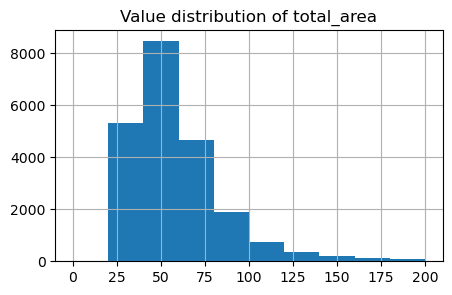

In [95]:
df['total_area'].hist(range=(0, 200), figsize=(5, 3))
print(df['total_area'].describe().round(2))
plt.title('Value distribution of total_area')
plt.show()

График распределения Пуассона, видно что большие значения более редки, чем малые. Логично, больших квартир довольно мало,
практически единичные экземпляры. Данное распределение не вызывает у меня подозрений, достаточно распространенная картина.

count    22119.00
mean        34.72
std         22.10
min          6.00
25%         18.80
50%         30.00
75%         43.00
max        409.70
Name: living_area, dtype: float64


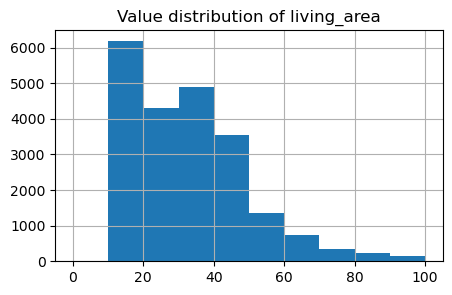

In [97]:
df['living_area'].hist(range=(0, 100), figsize=(5, 3))
print(df['living_area'].describe().round(2))
plt.title('Value distribution of living_area')
plt.show()

Та же самая картина, что и в предыдущем случае.

count    22119.00
mean        10.88
std          6.26
min          1.30
25%          7.10
50%          9.30
75%         12.00
max        112.00
Name: kitchen_area, dtype: float64


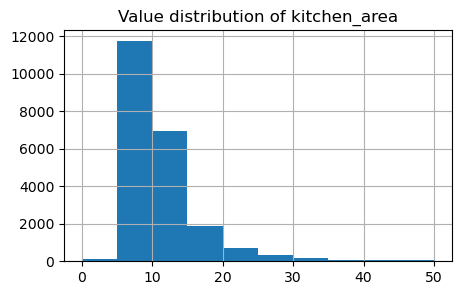

In [99]:
df['kitchen_area'].hist(range=(0, 50), figsize=(5, 3))
print(df['kitchen_area'].describe().round(2))
plt.title('Value distribution of kitchen_area')
plt.show()

Похоже на первые графики. Однако я заметил что на всех трех графиках, связанных с площадью помещений, в левой части видно, что существует какая-то аномально малая часть квартир с маленькой площадью. Общая площадь таких квартир около 20 кв. м. 
Возможно, можно эти данные удалить. Но, на мой взгляд, вклад этих данных небольшой. Тем более, что квартир с очень большой
площадью намного больше, и они будут больше искажать меры центральной тенденции выборки.

count    2.211900e+04
mean     6.533578e+06
std      1.097256e+07
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


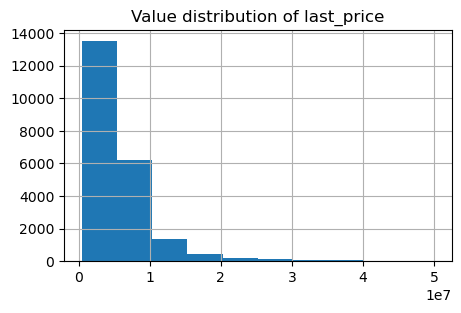

In [101]:
df['last_price'].hist(range=(400000, 50000000), figsize=(5, 3))
print(df['last_price'].describe().round(2))
plt.title('Value distribution of last_price')
plt.show()

Честно сказать, меня смущают минимальные и максимальные параметры данной величины. 
На мой взгляд, они очень отличаются от среднерыночных. Я бы узнал, сколько таких объектов.

In [102]:
df['last_price'].sort_values(ascending=False).head(10)

12971    763000000.0
19540    420000000.0
14706    401300000.0
1436     330000000.0
15651    300000000.0
22831    289238400.0
16461    245000000.0
13749    240000000.0
5893     230000000.0
8900     190870000.0
Name: last_price, dtype: float64

Удалю максимальное значение.

In [103]:
df['last_price'].sort_values().head(10)

8793      12190.0
17456    430000.0
9581     450000.0
17676    450000.0
5698     450000.0
23484    470000.0
18867    470000.0
16032    480000.0
10782    490000.0
14295    500000.0
Name: last_price, dtype: float64

Удалю минимальное значение

In [104]:
df = df.loc[~(df['last_price'] > 420000000)]
df = df.loc[~(df['last_price'] < 430000)]

count    22117.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64


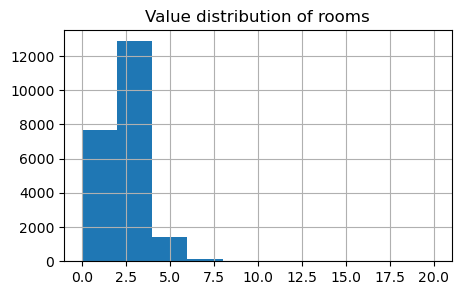

In [106]:
df['rooms'].hist(range=(0, 20), figsize=(5, 3))
print(df['rooms'].describe().round(2))
plt.title('Value distribution of rooms')
plt.show()

График похож на предыдущие, пока все ок.

count    13900.00
mean         2.73
std          0.29
min          2.00
25%          2.52
50%          2.65
75%          2.80
max          8.30
Name: ceiling_height, dtype: float64


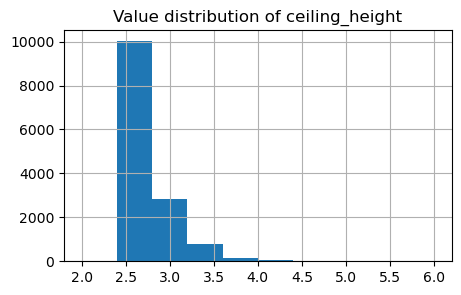

In [107]:
df['ceiling_height'].hist(range=(2, 6), figsize=(5, 3))
print(df['ceiling_height'].describe().round(2))
plt.title('Value distribution of ceiling_height')
plt.show()

Вполне ожидаемо, что пик значений приходится на 2 - 3 м, и постепенно снижение в сторону больших величин.

count    22117.00
mean         5.88
std          4.86
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         33.00
Name: floor, dtype: float64


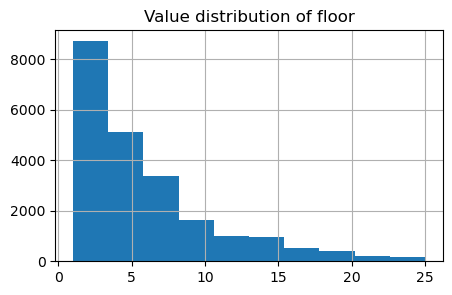

In [108]:
df['floor'].hist(range=(1, 25), figsize=(5, 3))
print(df['floor'].describe().round(2))
plt.title('Value distribution of floor')
plt.show()

Большинство квартир в датасете на 4 - 5 этаже. Что тоже логично, так как практически в каждом доме есть такие этажи, 
а вот высотки, превышающие 20 этажей, редки. Все то же распределение Пуассона, уходящее, если так можно выразиться, вправо.

In [109]:
df['floor_category'].value_counts()

другой       16287
последний     3126
первый        2704
Name: floor_category, dtype: int64

Логично, что промежуточных этажей большей всего.

count    22117.00
mean        10.66
std          6.56
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         35.00
Name: floors_total, dtype: float64


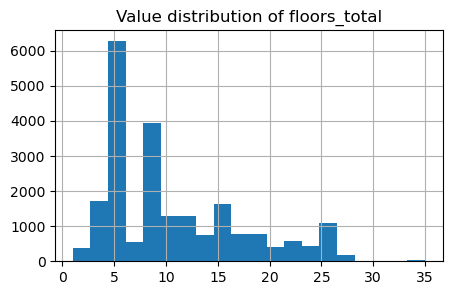

In [110]:
df['floors_total'].hist(bins=20, range=(1, 35), figsize=(5, 3))
print(df['floors_total'].describe().round(2))
plt.title('Value distribution of floors_total')
plt.show()

Полимодальное распределение, но все равно видно, что растянувшаяся правая часть диаграмы. Верхний ус ящика с усами здесь был в несколько раз нижнего. А впрочем можем и построить его.

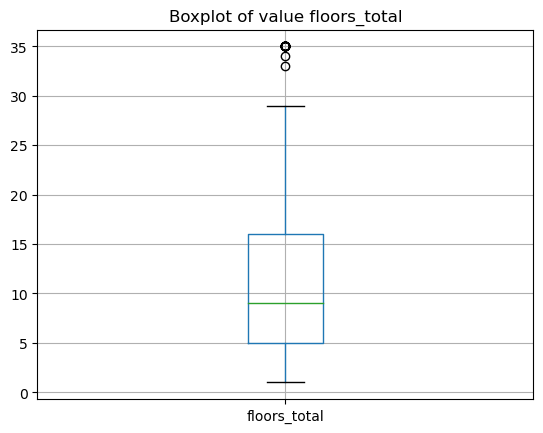

In [112]:
df.boxplot(column='floors_total')
plt.title('Boxplot of value floors_total')
plt.show()

Как и ожидалось - гигантский верхний ус, видны некоторые выбросы в районе 30 - 35 этажей. Оставлю их.

count    17188.00
mean     14255.95
std       8670.54
min        181.00
25%       9318.00
50%      13095.00
75%      16293.00
max      65968.00
Name: city_centers_nearest, dtype: float64


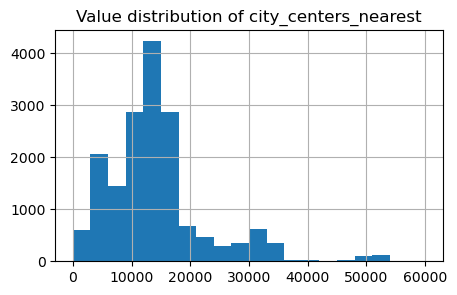

In [113]:
df['city_centers_nearest'].hist(bins=20, range=(0, 60000), figsize=(5, 3))
print(df['city_centers_nearest'].describe().round(2))
plt.title('Value distribution of city_centers_nearest')
plt.show()

Похожая картина на предыдущие графики. Есть небольшой всплеск (увеличение частоты) в районе 50 км.

count    17188.00
mean     28875.53
std      12683.98
min       6450.00
25%      18596.00
50%      26757.50
75%      37374.25
max      84869.00
Name: airports_nearest, dtype: float64


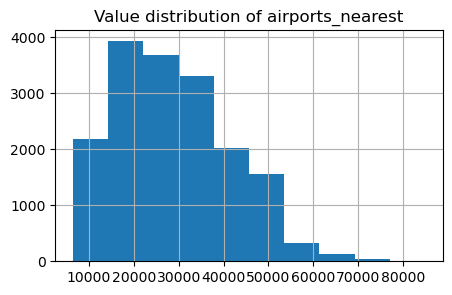

In [114]:
df['airports_nearest'].hist(figsize=(5, 3))
print(df['airports_nearest'].describe().round(2))
plt.title('Value distribution of airports_nearest')
plt.show()

Ничего нового в распределении данных.

count    22117.00
mean      2140.03
std       1208.91
min          3.00
25%        596.00
50%       3001.00
75%       3001.00
max       3190.00
Name: parks_nearest, dtype: float64


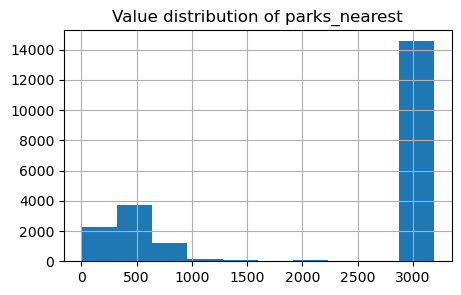

In [115]:
df['parks_nearest'].hist(figsize=(5, 3))
print(df['parks_nearest'].describe().round(2))
plt.title('Value distribution of parks_nearest')
plt.show()

Из-за того, что я заполнил недостающие ячейки значением 3001, у нас получился большой пик в правой части. 
Но если не рассматривать значения превышающие 3000, а взглянуть в выборку, где парки относительно рядом с квартирами, 
то мы обнаружим еще один пик в районе 500 м. Таких значений около 4000.

count        22117
unique           7
top       Thursday
freq          4033
Name: day_of_week, dtype: object


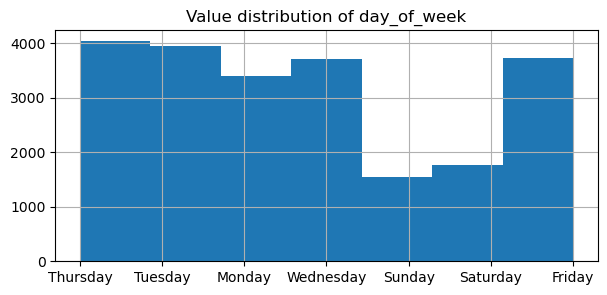

In [119]:
df['day_of_week'].hist(bins=7, figsize=(7, 3))
print(df['day_of_week'].describe())
plt.title('Value distribution of day_of_week')
plt.show()

Здесь, вроде, все логично. Большинство квартир выставляется на продажу в будние дни.

count    22117.000000
mean         6.419406
std          3.465821
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64


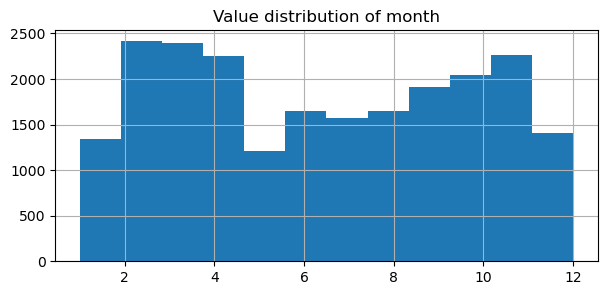

In [123]:
df['month'].hist(bins=12, figsize=(7, 3))
print(df['month'].describe())
plt.title('Value distribution of month')
plt.show()

По графику можно сказать, что зимой и летом квартиры выставляются куда реже.

**Вывод №1**

Распределение случайных величин отдельных параметров изученной выборки данных практически во всех случаях неравномерное, его можно охарактеризовать как Пуассоновское, когда меры центральной тенденции смещены в область малых значений.
Данная картина является довольно распространенной для подобных величин, поэтому можно смело продолжить анализ данных для выявления закономерностей.

Изучим то, как быстро продавались квартиры.

count    19055.000000
mean       184.768407
std        221.874820
min          1.000000
25%         44.000000
50%        100.000000
75%        238.000000
max       1580.000000
Name: days_exposition, dtype: float64


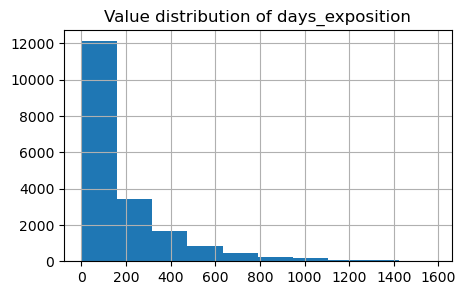

In [124]:
df['days_exposition'].hist(figsize=(5, 3))
print(df['days_exposition'].describe())
plt.title('Value distribution of days_exposition')
plt.show()

Итак, диапазон от 1 дня до 1580. Арифметическое среднее почти 185. Довольно долго. Но из-за того, что в нашем случае
правая часть графика сильно растянута, возможно, что среднее также сильно смещено в сторону больших значений. Об этом 
также говорит и стандартное отклонение, превышающее само среднее. А вот медиана равна 100 дням. Это уже намного лучше, 
и звучит разумнее.

Немного дтализируем гистограмму, чтобы изучить малые значения величины:

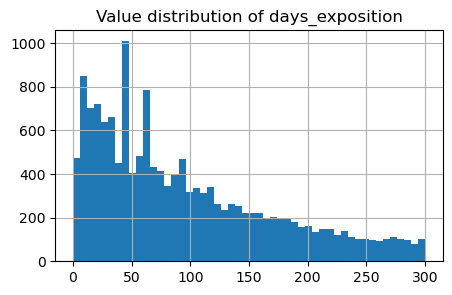

In [125]:
df['days_exposition'].hist(bins=50, range=(0, 300), figsize=(5, 3))
plt.title('Value distribution of days_exposition')
plt.show()

Видим, что более 9000 объектов были проданы и до медианного значения (100 дней). При еще более детальном рассмотрении видим
моду (более 1000 объектов), которая равна менее 50 дней. Должно быть, сама мода равна 40 с лишним дня. Но я для себя будусчитать, что быстрая продажа это та, которая осуществилась до 50 дней.

Детализируем гистограмму, чтобы изучить большие значения величины:

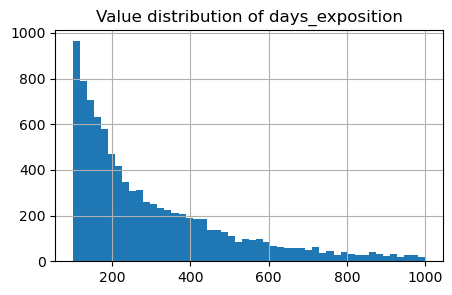

In [126]:
df['days_exposition'].hist(bins=50, range=(100, 1000), figsize=(5, 3))
plt.title('Value distribution of days_exposition')
plt.show()

В правом части гистограммы я не вижу каких-либо "всплесков", постепенно все меньше и меньше становится значений.
Видно, что значений, превышающих год, довольно мало, должно быть менее 2000.

In [234]:
df.loc[df['days_exposition'] > 365]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around_3000,ponds_nearest,days_exposition,modif_locality_name,sq_meter_price,day_of_week,month,year,floor_category,city_centers_km
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.3,4,False,...,2,574.0,558.0,Санкт-Петербург,92785.7,Thursday,8,2015,другой,14.0
13,20,3550000.0,42.80,2017-07-01,2,2.56,5,27.0,5,False,...,3,298.0,366.0,Петергоф,82943.9,Saturday,7,2017,последний,33.0
16,11,6700000.0,82.00,2017-11-23,3,3.05,5,55.6,1,False,...,0,3001.0,397.0,Санкт-Петербург,81707.3,Thursday,11,2017,первый,11.0
17,6,4180000.0,36.00,2016-09-09,1,NaN,17,16.5,7,False,...,1,859.0,571.0,Санкт-Петербург,116111.1,Friday,9,2016,другой,15.0
23,11,2950000.0,32.00,2016-10-29,1,2.60,9,17.7,9,False,...,1,190.0,615.0,Санкт-Петербург,92187.5,Saturday,10,2016,последний,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23672,5,3000000.0,30.80,2016-06-08,1,NaN,5,16.1,3,False,...,0,3001.0,808.0,Санкт-Петербург,97402.6,Wednesday,6,2016,другой,14.0
23675,8,3550000.0,39.50,2016-10-03,1,NaN,16,19.0,13,False,...,0,3001.0,721.0,Санкт-Петербург,89873.4,Monday,10,2016,другой,15.0
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25,40.3,7,False,...,1,806.0,519.0,Санкт-Петербург,129904.0,Thursday,10,2016,другой,4.0
23692,2,1350000.0,30.00,2017-07-07,1,NaN,5,17.5,4,False,...,0,3001.0,413.0,Тихвин,45000.0,Friday,7,2017,другой,NaN


Но больше года продавалось около 3000 объектов недвижимости из 19000 с лишним. Будем считать слишком долгими 
продажами те, которые совершаются больше 365 дней.

**Вывод №2**

Большинство объектов недвижимости продается в период около 100 дней, при этом быстрыми сделками можно считать те, которые совершились за 50 дней и менее. Долгими сделками можно считать те, что совершаются за год и более.

Изучим, какие факторы больше всего влияют на полную стоимость объекта:
Посмотри на зависимость полной стоимости и общей площади:

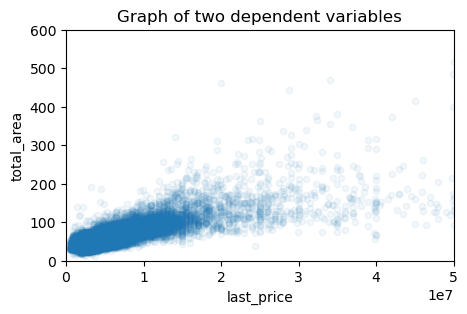

In [128]:
df.plot(x='last_price', xlim = (0, 50000000), y='total_area', ylim = (0, 600), 
        kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Graph of two dependent variables')
plt.show()

Вышеприведенный график демонстрирует, что существует прямая зависимость между значением площади и ценой, что логично.
Однако эта зависимость не такая большая, на графике можно увидеть два тренда, один начинается в области, близкой к нулю, и
идет круто вверх, а второй более полого. Вероятно, это связано с тем, что очень большие объекты не обладают большим спросом, что ведет к тому, что у них не сильно растет цена. В общем, прямой линейной зависимостью это не назовешь. Можно также отметить, что большинство объектов недвижимости обладают ценой до 15 млн и общей площадью до 100 кв м (наиболее плотная область на графике).

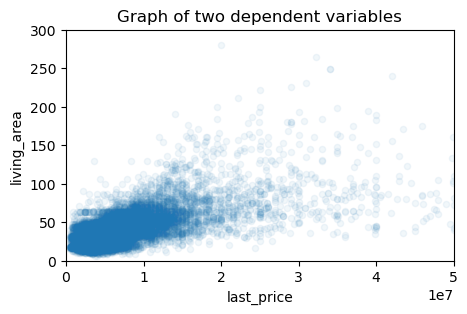

In [138]:
df.plot(x='last_price', xlim = (0, 50000000), y='living_area', ylim = (0, 300), 
        kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Graph of two dependent variables')
plt.show()

В слуаче с жилой площадью ситуация аналогичная.

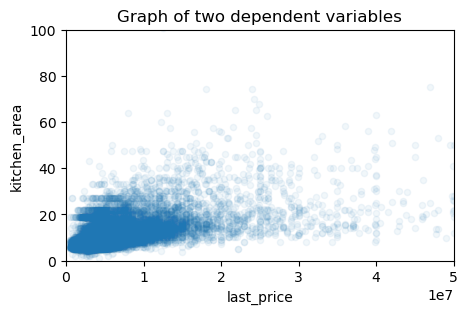

In [137]:
df.plot(x='last_price', xlim = (0, 50000000), y='kitchen_area', ylim = (0, 100), 
        kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Graph of two dependent variables')
plt.show()

По графику можно сделать вывод, что между ценой и площадью кухни существует маленькая положительная зависимость. Но есть 
в выборке данные, для которых эта зависимость стремится к нулю, т. е. график для них становится похожим на горизонтальную
прямую.

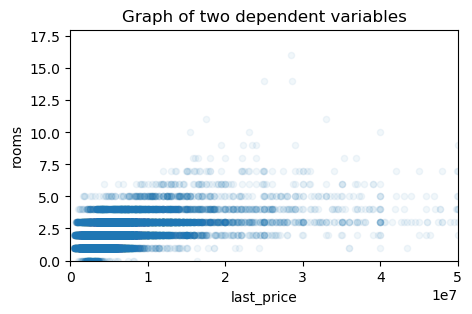

In [136]:
df.plot(x='last_price', xlim = (0, 50000000), y='rooms', ylim = (0, 18), 
        kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Graph of two dependent variables')
plt.show()

Для большинства данных практически не наблюдается зависимость цены от количества комнат. Вероятно, это связано с тем, что 
объекты спланированы по разному, когда, к примеру, большая квартира может содержать 2 комнаты или 6. 

Для подтверждения выше выдвинутой гипотезы построим график зависимости общей площади от количества комнат.

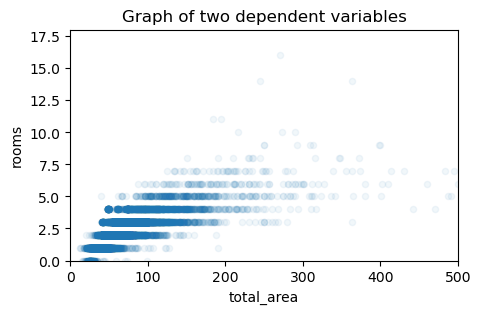

In [139]:
df.plot(x='total_area', xlim = (0, 500), y='rooms', ylim = (0, 18), 
        kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Graph of two dependent variables')
plt.show()

Действительно видим, что некоторые квартиры с 4 комнатами могут обладать площадью 100, 200 или 300 кв. м. Но такой же
площадью могут обладать и 3- или 5-комнатные квартиры.

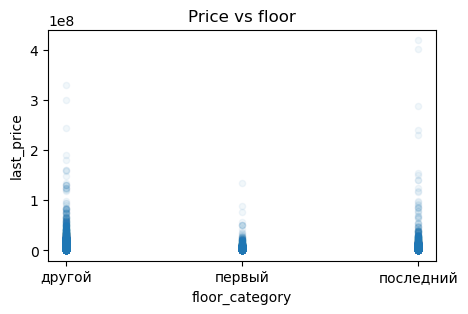

In [140]:
df.plot(x='floor_category', y='last_price', kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Price vs floor')
plt.show()

График зависимости цены от этажа показывает, что дешевле всего квартиры на первом этаже. Логично. Чуть дороже квартиры на
последнем, ну и дороже всех квартиры промежуточные.

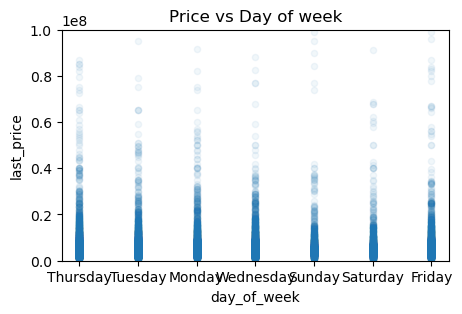

In [142]:
df.plot(x='day_of_week', y='last_price', ylim = (0, 100000000), kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Price vs Day of week')
plt.show()

В целом заметная небольшая тенденция, что квартиры, объявления о которых были размещены на выходных, были проданы по 
меньшей цене. Самые высокие цены - если объявление было размещено в середине недели. Но последний вывод не так очевиден.

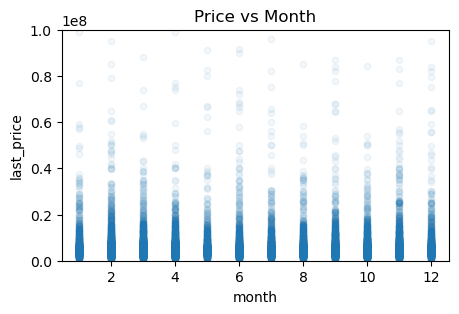

In [143]:
df.plot(x='month', y='last_price', ylim = (0, 100000000), kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Price vs Month')
plt.show()

На мой взгляд существует небольшая зависимость, совсем слабая - по более высокой цене продаются квартиры,
объявления о которых были размещены в конце и начале года.

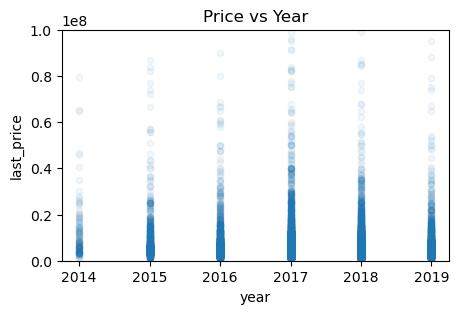

In [144]:
df.plot(x='year', y='last_price', ylim = (0, 100000000), kind='scatter', alpha=0.06, figsize=(5, 3))
plt.title('Price vs Year')
plt.show()

По этому графику можно сделать вывод, что цены на недвижимость росли росли до 2017 - 2018, а потом немного упали.

Посмотри на коэффициенты корреляции для количественных переменных, так как только для них это наиболее корректно.

In [145]:
df['last_price'].corr(df['total_area']).round(2), \
df['last_price'].corr(df['living_area']).round(2), \
df['last_price'].corr(df['kitchen_area']).round(2), \
df['last_price'].corr(df['rooms']).round(2), 

(0.7, 0.61, 0.49, 0.39)

Видим что, наиболее сильные связи между общей площадью и ценой, и самые малые - между площадью кухни и ценой. 
Еще меньше корреляция между ценой и числом комнат.
Об этом говорили и графики.

Посмотрим, как зависит стоимость квартиры от числа комнат и этажа одновременно, выведем только квартиры с 0 - 9 комнатами,
так как квартир с большим числом комнат чуть более десятка, и не на всех этажах они представлены, т.е. по ним нет статистики.
Может стоило изначально удалить эти данные из датасета.

In [146]:
pivot_table1 = (
    pd.pivot_table(df, index='rooms', columns='floor_category', values='last_price', aggfunc=['median','count']).head(10)
)
pivot_table1.columns = ['other_median', 'first_median', 'last_median', 'other_counts', 'first_counts', 'last_counts']
pivot_table1

,other_median,first_median,last_median,other_counts,first_counts,last_counts
rooms,,,,,,
0,2750000.0,2183000.0,3200000.0,163.0,18.0,11.0
1,3700000.0,3100000.0,3200000.0,5867.0,754.0,856.0
2,5150000.0,3899500.0,4150000.0,5232.0,1046.0,1142.0
3,6500000.0,5000000.0,5800000.0,3947.0,682.0,818.0
4,9775000.0,6500000.0,9600000.0,762.0,149.0,189.0
5,14000000.0,10000000.0,20750000.0,200.0,39.0,60.0
6,19000000.0,16675500.0,19500000.0,66.0,8.0,25.0
7,24950000.0,24000000.0,20500000.0,36.0,3.0,14.0
8,19900000.0,22190000.0,46000000.0,5.0,3.0,4.0


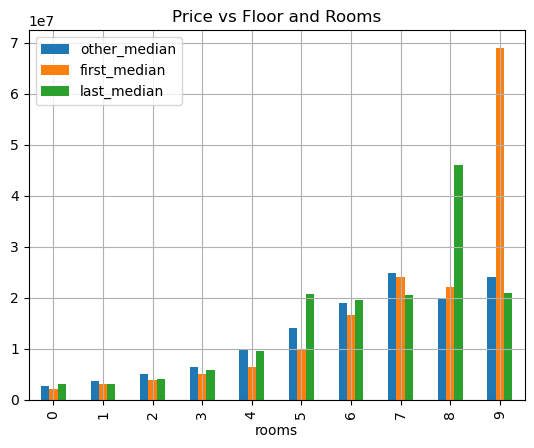

In [147]:
pivot_table1[['other_median', 'first_median', 'last_median']].plot(kind='bar', grid=True)
plt.title('Price vs Floor and Rooms')
plt.show()

График показывает, что с увеличением числа комнат практически во всех случаях средняя цена объекта выше всего на
промежуточных этажах. Исключениями являются объекты с 5, 6 и 8 комнатами, среди них самые дорогие экземпляры находятся 
на последних этажах. Вообще статистика и по квартирам с 8 и 9 комнатами тоже весьма непредставительна, число 8-комнтаных - 12, число 9-комнатных - 7.

In [149]:
pivot_table2 = (
    pd.pivot_table(df, index='month', columns='day_of_week', values='last_price', aggfunc=['median'])
)
pivot_table2.columns = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
pivot_table2

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
1,4650000.0,4699000.0,4706250.0,4350000.0,4599500.0,4650000.0,5249000.0
2,4490000.0,4600000.0,4605000.0,4400000.0,4670000.0,4900000.0,4998000.0
3,4700000.0,4500000.0,4425000.0,4800000.0,4700000.0,4700000.0,4800000.0
4,4900000.0,4850000.0,4470000.0,4690000.0,4800000.0,4900000.0,4900000.0
5,4648000.0,4625000.0,4500000.0,3945000.0,4800000.0,4150000.0,4700000.0
6,4400000.0,4750000.0,4720000.0,4095000.0,4640000.0,4600000.0,4195000.0
7,4190000.0,4850000.0,4450000.0,4750000.0,4650000.0,4600000.0,4725000.0
8,4500000.0,4990000.0,4450000.0,4570000.0,4375000.0,4500000.0,4680000.0
9,4580000.0,4495000.0,4500000.0,4800000.0,4525000.0,5000000.0,4794500.0


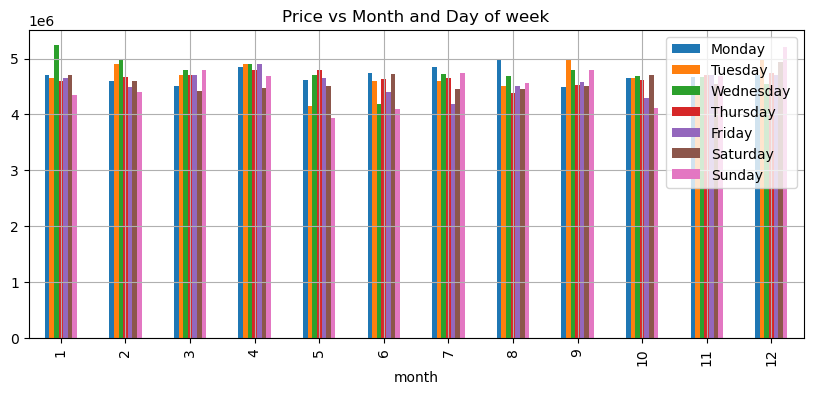

In [155]:
pivot_table2[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]\
.plot(kind='bar', grid=True, figsize=(10, 4))
plt.title('Price vs Month and Day of week')
plt.show()

График показывает, что в первой половине года дороже всего продавались квартиры в середине недели, в июне, июле и сентябре
лидировал понедельник, а затем все квартиры независимо от дня недели продавались плюс минус по одинаковой цене.

**Вывод №3**

Исследование графиков и сводных таблиц с участием цены объектов и других параметров позволило выявить следующие особенности.

Между ценой и общей площадью, ценой и площадью комнат существует прямая корреляция, при этом наибольший коэффициент корреляции в первом случае (0. 70). 
Корреляция между числом комнат и ценой не такая высокая, как могли бы ожидать - 0.39. Это, в свою очередь, может быть связано с тем, что квартиры обладающие большим количеством комнат не всегда обладают большой площадью, т. е. той величиной, которая больше всего влияет на цену.

Исследование показало, что наибольшей ценой обладают объекты расположенные между первым и последним этажом здания. Самые дешевые объекты располагаются на первом этаже.
 
 Нельзя выявить никаких серьезных закономерностей зависимости цены от дня и недели размещения объявления. Но все же можно сказать, что те объекты, которые были выставлены на продажу в будние дни, обладали наиболее высокими ценами. Также более дорогими оказались квартиры, выставленные на продажу в начале и конце года(зимой).
Также было выявлено, что цена недвижимости росла до 2017 - 2018 года, но затем стала снижаться.

Исследование также показало, что квартиры с 5 и 6 комнтатами, являются более дорогими, если они располагаются на последних этажах. Возможно, это было бы справедливо и для более многокомнатных квартир, если бы были более представительные данные. Отчасти этот вывод справедлив, возможно, люди охотнее покупают более просторные квартиры, если они располагаются на последнем этаже.

Исследование стоимости квадратного метра жилья в городах с наибольшим количеством заявок.

In [156]:
grouped_table1 = df.groupby('modif_locality_name').agg({'sq_meter_price':['median', 'count']})
grouped_table1.columns = ['sq_m_median', 'counts']

In [157]:
top_10_counts = grouped_table1.sort_values(by='counts', ascending=False).head(10)
top_10_counts

,sq_m_median,counts
modif_locality_name,,
Санкт-Петербург,104685.90,14787
Мурино,86417.00,544
Кудрово,95918.90,433
Шушары,77312.80,408
Всеволожск,65789.50,371
Пушкин,100000.00,346
Колпино,74723.75,328
Парголово,91579.75,302
Гатчина,67860.55,296


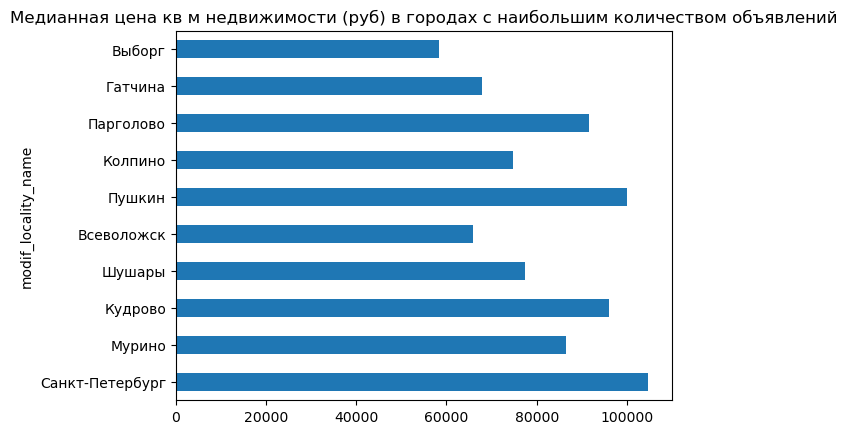

In [159]:
top_10_counts.plot(kind='barh', y='sq_m_median', title = \
                   'Медианная цена кв м недвижимости (руб) в городах с наибольшим количеством объявлений',\
                  legend=False, xlabel='')
plt.show()

**Вывод №4**

Исследование средней стоимости 1 кв м в городах с наибольшим числом объявлений показало следующее. На первом месте по стоимости 1 кв м, ожидаемо, Санкт-Петербург. За ним идут Пушкин и Кудрово. На последних местах - Выборг, Всеволожск, Гатчина.

Исследуем, как стоимость объектов г. Санкт-Петербурга зависит от расстояния до центра города.
Сначала создадим датасет, где данные только для СПб:

In [160]:
spb_real_estate = df.loc[df['modif_locality_name']=='Санкт-Петербург']

Дропнем в нем индексы:

In [162]:
spb_real_estate.reset_index(drop=True, inplace=True)

Посмотрим как изменяется цена 1 кв м в зависимости расстояния от центра:

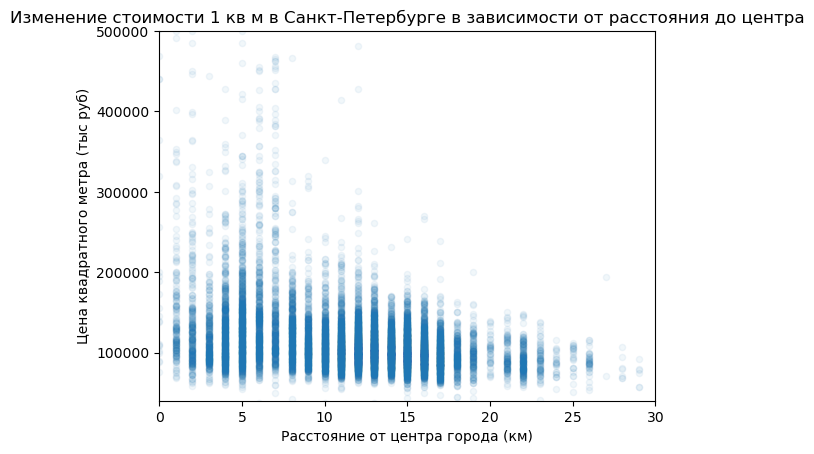

In [163]:
spb_real_estate.plot(x='city_centers_km', y='sq_meter_price', kind='scatter', \
                     ylim = (40000, 500000), xlim = (0, 30), alpha=0.06, \
                     title='Изменение стоимости 1 кв м в Санкт-Петербурге в зависимости от расстояния до центра',\
                    ylabel='Цена квадратного метра (тыс руб)', xlabel='Расстояние от центра города (км)')
plt.show()

График показывает, что примерно до 5 км цена растет, но уже дальше, как и ожидалось, начинает падать.
Небольшой парадокс. Посмотрим на коэффициент корреляции:

In [164]:
(spb_real_estate['city_centers_km'].corr(spb_real_estate['sq_meter_price'])).round(2)

-0.32

Логично, что коэффициент отрицательный, но связь весьма невысокая.

Теперь рассчитаем для каждого километра медианное значение стоимости квадратного метра.
Но для начала изменим тип столба 'city_centers_km':

In [165]:
spb_real_estate['city_centers_km'] = spb_real_estate['city_centers_km'].astype('int64')

Теперь посчитаем медианные значения:

In [166]:
for i in spb_real_estate['city_centers_km'].unique():
    spb_real_estate.loc[(spb_real_estate['city_centers_km'] == i), 'price_per_km'] =\
    spb_real_estate.loc[(spb_real_estate['city_centers_km'] == i), 'sq_meter_price'].median()

Построим все тот же график, что и раньше, но теперь для средней стоимости квадратного метра для каждого километра:

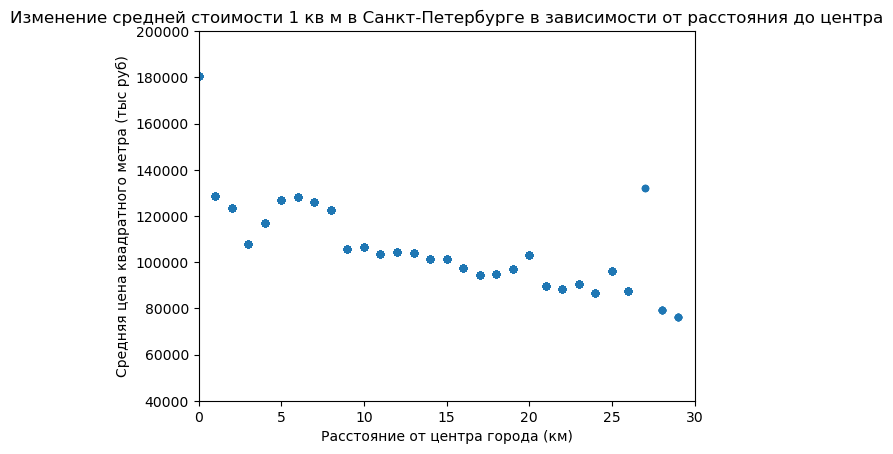

In [168]:
spb_real_estate.plot(x='city_centers_km', y='price_per_km', kind='scatter', \
                     ylim = (40000, 200000), xlim = (0, 30), \
                     title='Изменение средней стоимости 1 кв м в Санкт-Петербурге в зависимости от расстояния до центра',\
                    ylabel='Средняя цена квадратного метра (тыс руб)', xlabel='Расстояние от центра города (км)')
plt.show()

Можем наблюдать интересную картину, график изменения средней стоимости квадратного метра жилья на каждом километре удаленности
от центра немного противоречит предыдущему графику, по которому вывод делался только по плотности всех точек на графике. 
На последнем графике заметно, что на первых 3 км от центра стоимость кв м падает, что логично, потом растет (до 6 км), 
а потом снова падает (что уже совпадает с предыдущим графиком). Доверимся медиане.

**Вывод №5**

Исследование стоимости 1 кв м в Санкт-Петербурге в зависимости от удаленности от центра показало следующее. Нельзя сказать, что удаленность от центра города напрямую влияет на стоимость квадратного метра квартиры, например, коэффициент корреляции составляет всего лишь -32. Природа связи данных параметров не так проста. Удалось выявить, что на расстоянии от 0 до 3 км от центра средняя цена квадратного метра ожидаемо падает от 180 тыс руб до 110 тыс руб. От 3 км до 6 км от центра стоимость уже увеличивается до примерно 130 тыс руб. От 6 км от центра стоимость уже ведет себя достаточно предсказуемо, понижаясь все больше и больше, достигая значения менее 80 тыс руб.

## Заключение

<div style="background: #ffffff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <br />
    <font color='4682B4'>Тема исследования: Изучение базы данных "Яндекс. Недвижимость" с целью выявления факторов, влияющих на различные параметры купли-продажи недвижимости в Санкт-Петербурге и Ленинградской области. </font><br />
    <br />
    <font color='4682B4'>Задачи исследования: </font><br />
    <br />
    <font color='4682B4'>1. Оценка времени продажи объекта недвижимости </font><br />
    <br />
    <font color='4682B4'>2. Оценка факторов, влияющих на общую стоимость объекта недвижимости </font><br />
    <br />
    <font color='4682B4'>3. Выявление населенных пунктов с самой высокой и самой низкой стоимостью одного квадратного метра объекта недвижимости </font><br />
    <br />
    <font color='4682B4'>4. Выявление связи цены одного квадратного метра объета и удаленности от центра в Санкт-Петербурге </font><br />
    <br />
    <font color='4682B4'> Основные выводы:</font>
    <br />
    <br />
    <font color='4682B4'>1. Большинство объектов недвижимости продается в период около 100  дней (всего более 50%), при этом быстрыми сделками можно считать те, которые совершились за 50 дней и менее. Долгими сделками можно считать те, что совершаются за год и более (всего 10%). </font><br />
    <br />
    <font color='4682B4'>2. Больше всего на общую цену объекта влияет общая площадь объекта (коэффициент корреляции Пирсона = 0.70). А вот количество комнат в квартире не всегда вызывает увеличение ее цены. Это может быть связано с тем, что квартиры, обладающие большим количеством комнат, не всегда обладают большой площадью, тем параметром, который больше всего влияет на цену.</font>
    <br />
    <font color='4682B4'>Наибольшей ценой обладают объекты расположенные между первым и последним этажом здания. Самые дешевые объекты располагаются на первом этаже.</font>
    <br />
    <font color='4682B4'>Нельзя выявить никаких серьезных закономерностей зависимости цены от дня и недели размещения объявления. Но все же можно сказать, что те объекты, которые были выставлены на продажу в будние дни, обладали наиболее высокими ценами. Также более дорогими оказались квартиры, выставленные на продажу зимой.
Также было выявлено, что цена недвижимости росла до 2017 - 2018 года, но затем стала снижаться.</font>
    <br />
    <font color='4682B4'>Квартиры с 5 и 6 комнтатами, являются более дорогими, если они располагаются на последних этажах. Чтобы сделать подобный вывод о квартирах с большим числом комнат, необходимы дополнительные данные. Возможно, люди охотнее покупают более просторные квартиры, если они располагаются на последнем этаже.</font>
    <br />
    <br />
    <font color='4682B4'> 3. Как и ожидалось, на первом месте по стоимости 1 кв м Санкт-Петербург (около 105 тыс руб). За ним идут Пушкин и Кудрово. На последних местах - Гатчина, Всеволожск и Выборг. Для последнего стоимость 1 кв м составила менее 60 тыс руб. Данный вывод подверждает предположение, что чем дальше город от Санкт-Петербурга, тем дешевле в нем недвижимость.</font>
    <br />
    <br />
    <font color='4682B4'>4. Пирода связи средней стоимости квадратного метра от удаленности от центра в Санкт-Петербурге носит сложный характер. На расстоянии от 0 до 3 км от центра средняя цена квадратного метра ожидаемо падает от 180 тыс руб до 110 тыс руб. От 3 км до 6 км от центра стоимость уже увеличивается до примерно 130 тыс руб. Это может быть связано с тем, что в небольшой удаленности от центра Санкт-Петербурга существуют элитные жилые кварталы, где рядом парковые зоны и водоемы (например, Крестовский). От 6 км от центра стоимость уже ведет себя достаточно предсказуемо, понижаясь все больше и больше, достигая значения менее 80 тыс руб.</font>
    <br />
    <br />
    <font color='4682B4'>P.S. Если что, прошу прощения за очепятки :)</font>
    <br />
</div>